# XGBoost

In this tutorial we learn how to process data, train an XGBoost model and validate any model.

# Import packages

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from pathlib import Path
from openpyxl import Workbook

In [94]:
# set width of Jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# set some visual properties of displaying pandas DataFrame
pd.options.display.max_columns=200
pd.options.display.max_rows=200

# zkousim, jestli to delam spravne

**Download the data if needed (and unpack it into the Data folder), we use the same dataset as in the python intro:** <a href="https://www2.karlin.mff.cuni.cz/~kozmikk/files/data_devsample.zip" target="_blank">credit risk data</a> 

# Load Data
- Data sample represents data used in financial institutions for development of credit risk scoring models.
- This data sample was used in Kaggle competition arranged by Home Credit Group in 2018.
- Data includes binary target variable `TARGET` and multiple regressors to be used in model.
- Column `SK_ID_CURR` is used as unique identifier of credit application and columns `TIME` represents time of the application.
- Model should predict solvency of applicants at the time of application for credit.

In [95]:
# Load data - set index column, decimal point, separator
data_file = Path("../Assigment1/Data1/2024_DS2_HW1_data_train.csv")
data = pd.read_csv(data_file, sep = ',', decimal = '.', index_col = 'Booking_ID')

# print time of data being loaded - use strftime
print(f'Data loaded on:   {datetime.datetime.now().strftime(format="%Y-%m-%d %H:%M:%S")}')

Data loaded on:   2024-04-18 21:00:21


In [4]:
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0


In [5]:
# Print some numbers about data sample size
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {data.shape[1]:,}'.replace(',', ' '))

Number of rows:   32 647
Number of unique indexes:   32 647
Number of columns:   18


# Metadata Definitions

In [62]:
# check values in column booking_status
data.booking_status.value_counts(dropna=False)

booking_status
0.0    21774
1.0    10521
NaN      352
Name: count, dtype: int64

In [98]:
#tohle zatím nevím k čemu je

#name of the target column
col_target = "booking_status"
#name of the time column - nemáme?
# col_time = "TIME"

#name of the month column
col_month = "arrival_month"

In [99]:
# define list of predictors
cols_pred = list(data.columns[0:-1])

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']

print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
no_of_adults                            float64
no_of_children                          float64
no_of_weekend_nights                    float64
no_of_week_nights                       float64
required_car_parking_space              float64
lead_time                               float64
arrival_year                            float64
arrival_month                           float64
arrival_date                            float64
repeated_guest                          float64
no_of_previous_cancellations            float64
no_of_previous_bookings_not_canceled    float64
avg_price_per_room                      float64
no_of_special_requests                  float64
dtype: object

Categorical predictors:
-----------------------
type_of_meal_plan      object
room_type_reserved     object
market_segment_type    object
dtype: object


In [120]:
# convert col_time to date - nepotřebujeme
#if data[col_time].dtype == 'O':
#    data[col_time] = data[col_time].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())


# Count occurrences of each category in 'type_of_meal_plan'
meal_plan_counts = data['type_of_meal_plan'].value_counts()

# Count occurrences of each category in 'room_type_reserved'
room_type_counts = data['room_type_reserved'].value_counts()

# Count occurrences of each category in 'market_segment_type'
market_segment_counts = data['market_segment_type'].value_counts()

print("Count of categories in 'type_of_meal_plan':")
print(meal_plan_counts)
print("\nCount of categories in 'room_type_reserved':")
print(room_type_counts)
print("\nCount of categories in 'market_segment_type':")
print(market_segment_counts)

Count of categories in 'type_of_meal_plan':
type_of_meal_plan
Meal Plan 1     12767
Not Selected     2290
Meal Plan 2      1484
Meal Plan 3         3
Name: count, dtype: int64

Count of categories in 'room_type_reserved':
room_type_reserved
Room_Type 1    8812
Room_Type 4    1847
Room_Type 6     325
Room_Type 2     233
Room_Type 5      84
Room_Type 7      58
Room_Type 3       1
Name: count, dtype: int64

Count of categories in 'market_segment_type':
market_segment_type
Online           11884
Offline           5328
Corporate         1038
Complementary      215
Aviation            61
Name: count, dtype: int64


# Data Split

In [100]:
# define function to plot default rate in time for different samples
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, 'mean')
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 1])
    plt.ylabel('default rate')
    plt.xlabel('month')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray')
        
    plt.show()

In [101]:
data['sample'] = 'default'

# define 'hoot' and 'oot' sample
#nemáme, doufám



# define intime mask
target_mask = (data[col_target] >= 0) & (data[col_target] <= 1) #!!!ODSTRANÍ ŘÁDKY KDE JE BOOKING_STATU MIMO [0,1]!!!

# use train_test_split to split the intime into train and rest (don't forget seed); use stratification
data_train, data_rest = train_test_split(data[target_mask], test_size=0.1, random_state = 12, stratify = (data[target_mask][[col_target]]))
data.loc[data_train.index, 'sample'] = 'train'
# use train_test_split to split the rest into valid and test (don't forget seed); use stratification
data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12, stratify = (data_rest[[col_target]]))
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

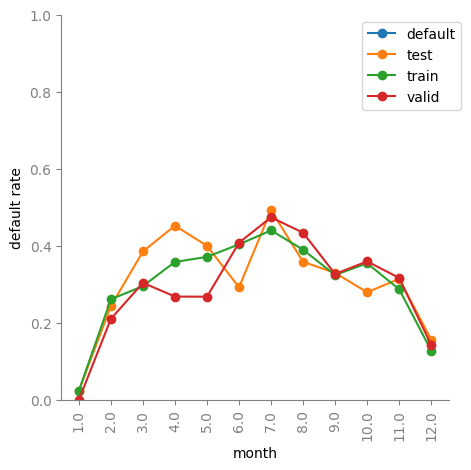

In [102]:
default_rate_in_time_per_sample(data, col_target, col_month, 'sample')

## Define Sample Masks

In [103]:
# define sample masks
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid') 
test_mask = (data['sample'] == 'test') 
#oot_mask = (data['sample'] == 'oot')  
#hoot_mask = (data['sample'] == 'hoot')

# Data preprocessing

## Replace infinity

In [104]:
# v našich datech žádné nejsou

# find columns with infinity values
cols_with_inf = []
for col in cols_pred_num:
    if np.any(np.isinf(data[col])):
        cols_with_inf.append(col)
        print(f'Column {col} includes infinity values.')

# find columns with negative infinity values
cols_with_neginf = []
for col in cols_pred_num:
    if np.any(np.isneginf(data[col])):
        cols_with_neginf.append(col)
        print(f'Column {col} includes negative infinity values.')

In [70]:
# replace infinity values
for col in cols_with_inf:
    data[col] = data[col].replace(np.inf, 9999999)

## Encode Categorical Predictors
- Category encoding is defined by:
$$ CategoryEncoding = \frac{f_{categ}\cdot Booking_{category} + \alpha \cdot Booking}{f_{categ} + \alpha} $$
where $f_{categ}$ is frequency of category to be encoded, $Booking_{category}$ average booking status in this category and $Booking$ is overall average booking status.

In [105]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_booking = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_booking = (target, 'mean'),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_booking'] + alpha * total_booking) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

#Tady možná změna? 0.001?

In [24]:

len(data["type_of_meal_plan"].unique())

5

In [106]:
total_booking = np.mean(data[train_mask][col_target])

#jestli to chápu správně, tak ta if podmínka je nesplnitelná, takže to používá ten druhý postup, což je mean target encoding, můžeme přenastavit na one-hot otočením podmínky
# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0: #pro kategorické veličiny, které nemají ani jednu skupinu
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_booking

        data['MTE_' + pred] = data[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/3 [00:00<?, ?it/s]

In [119]:
cols_pred

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'MTE_type_of_meal_plan',
 'MTE_room_type_reserved',
 'MTE_market_segment_type']

# XGBoost model
- XGBoost model is provided in package `xgboost`
- https://xgboost.readthedocs.io/en/stable/

## First XGBoost model
- **early stopping:** Model is trained on training sample and we control model performance on evaluation sample (can be valid or test). If the model does not improve after *n* iterations, we stop the training.
- Data must be passed to training as *xgb.DMatrix* data type.
- Parameter *dtrain* defines data set to be used for training. Parameter evals is used for passing evaluation data sets - eval_metric will be evaluated on those sets in each iteration. Last data set from evals is used for early stopping.

In [128]:
#MY BEST MODEL SO FAR

# set best parameters to be used in XGBoost
#cols_pred.remove('no_of_previous_cancellations')  #'no_of_previous_cancellations', no_of_children
params = {    
    'eta': 0.1,
    'max_depth': 6,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)


[0]	train-auc:0.75680	test-auc:0.76353	valid-auc:0.74151
[1]	train-auc:0.76941	test-auc:0.77557	valid-auc:0.74977
[2]	train-auc:0.77024	test-auc:0.77522	valid-auc:0.75427
[3]	train-auc:0.77740	test-auc:0.77868	valid-auc:0.75881
[4]	train-auc:0.77918	test-auc:0.77772	valid-auc:0.75795
[5]	train-auc:0.78425	test-auc:0.78480	valid-auc:0.76280
[6]	train-auc:0.78520	test-auc:0.78689	valid-auc:0.76590
[7]	train-auc:0.78594	test-auc:0.78849	valid-auc:0.76698
[8]	train-auc:0.78938	test-auc:0.79109	valid-auc:0.77074
[9]	train-auc:0.79178	test-auc:0.79239	valid-auc:0.77019
[10]	train-auc:0.79398	test-auc:0.79388	valid-auc:0.77141
[11]	train-auc:0.79585	test-auc:0.79476	valid-auc:0.77154
[12]	train-auc:0.79782	test-auc:0.79724	valid-auc:0.77402
[13]	train-auc:0.79995	test-auc:0.79878	valid-auc:0.77559
[14]	train-auc:0.80157	test-auc:0.79943	valid-auc:0.77586
[15]	train-auc:0.80231	test-auc:0.79971	valid-auc:0.77622
[16]	train-auc:0.80404	test-auc:0.80036	valid-auc:0.77822
[17]	train-auc:0.80541	t

In [109]:
#ORIGINAL MODEL

params = {    
    'max_depth': 4,
    'objective': 'binary:logistic',
    'eval_metric': ['auc'],
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)


[0]	train-auc:0.70893	test-auc:0.71987	valid-auc:0.68204
[1]	train-auc:0.74449	test-auc:0.74957	valid-auc:0.72034
[2]	train-auc:0.75955	test-auc:0.75939	valid-auc:0.73374
[3]	train-auc:0.77057	test-auc:0.77677	valid-auc:0.75031
[4]	train-auc:0.77521	test-auc:0.78016	valid-auc:0.75561
[5]	train-auc:0.78331	test-auc:0.78589	valid-auc:0.76520
[6]	train-auc:0.78983	test-auc:0.79241	valid-auc:0.77329
[7]	train-auc:0.79383	test-auc:0.79383	valid-auc:0.77571
[8]	train-auc:0.79524	test-auc:0.79699	valid-auc:0.77728
[9]	train-auc:0.79578	test-auc:0.79527	valid-auc:0.77715
[10]	train-auc:0.79804	test-auc:0.79720	valid-auc:0.77970
[11]	train-auc:0.79959	test-auc:0.79727	valid-auc:0.77918
[12]	train-auc:0.80161	test-auc:0.79822	valid-auc:0.78137
[13]	train-auc:0.80371	test-auc:0.80071	valid-auc:0.78444
[14]	train-auc:0.80465	test-auc:0.80176	valid-auc:0.78493
[15]	train-auc:0.80517	test-auc:0.80224	valid-auc:0.78529
[16]	train-auc:0.80611	test-auc:0.80346	valid-auc:0.78682
[17]	train-auc:0.80694	t

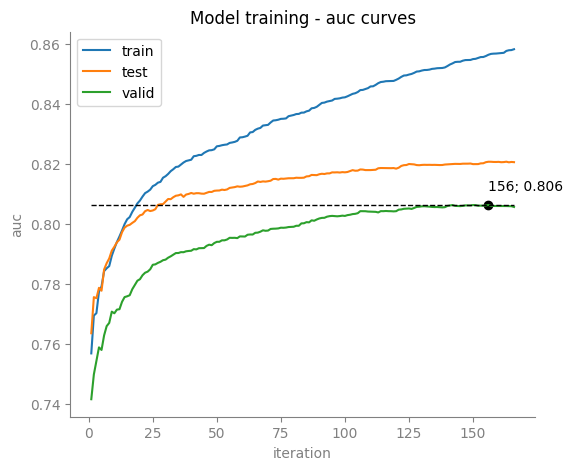

In [129]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1
#best_iteration = 51
ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

# plt.savefig('test.svg', format='svg')
# plt.close()

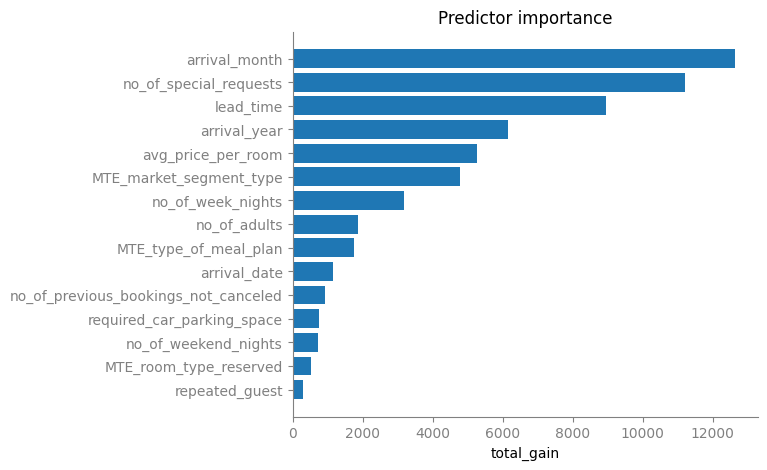

In [152]:
importance_type = 'total_gain'

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])

fig = plt.figure(figsize=(6,5))

n_strongest = 15
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:15])
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:15])
plt.xlabel(importance_type)
plt.title('Predictor importance')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

In [132]:
# Load test data - set index column, decimal point, separator
test_data_file = Path("../Assigment1/Data1/2024_DS2_HW1_data_test.csv")
test_data = pd.read_csv(test_data_file, sep = ',', decimal = '.', index_col = 'Booking_ID')

# print data info
print(f'Number of rows:   {test_data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {test_data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {test_data.shape[1]:,}'.replace(',', ' '))

Number of rows:   3 593
Number of unique indexes:   3 593
Number of columns:   17


In [133]:
#ENCODING FOR TARGET
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(test_data[test_data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_booking

        test_data['MTE_' + pred] = test_data[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/3 [00:00<?, ?it/s]

In [90]:
#PREDICTION FOR THE TEST DATA
dtest = xgb.DMatrix(test_data[cols_pred])
ypred = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1))

array([0.0019282 , 0.19537382, 0.17379986, ..., 0.9317546 , 0.01202485,
       0.18967463], dtype=float32)

In [91]:
#MAKING DATA FRAME FOR PREDICTION
# Predict probabilities on the training data

test_data_reset = test_data.reset_index()

# Create a DataFrame with booking IDs and predicted probabilities
predictions_df = pd.DataFrame({
    'Booking_ID': test_data_reset['Booking_ID'],  # Assuming 'Booking_ID' is the name of the index
    'booking_status': ypred
})
predictions_df

,Booking_ID,booking_status
0,INN04969,0.001928
1,INN34541,0.195374
2,INN36109,0.173800
3,INN01554,0.739715
4,INN24975,0.217642
...,...,...
3588,INN29523,0.038306
3589,INN25061,0.436698
3590,INN08475,0.931755
3591,INN13558,0.012025


In [33]:
#pip install openpyxl

     -------------------------------------- 250.0/250.0 kB 3.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [92]:
#EXPORTING PREDICTION
predictions_df.to_excel("predictions4.xlsx", index=False)

print("DataFrame successfully exported to Excel.")

DataFrame successfully exported to Excel.


## XGBoost in sklearn

In [148]:
#NEW ATEMPT USING SKLEARN
booster_sklearn = xgb.XGBClassifier(
    tree_method = 'exact',
    booster='gbtree', #which booster to use
    objective='binary:logistic', #specify the learning task (objective function)
    random_state=12, #random seed
    verbosity=1, #amount of info in printing
    eval_metric='auc',
    max_depth = 7,
    eta = 0.05,
    use_label_encoder=False,
    early_stopping_rounds=10,#acttivates early stopping
)

booster_sklearn.fit(
    data[train_mask][cols_pred].values, 
    data[train_mask][col_target].astype(int).values,
    eval_set=[
        (data[train_mask][cols_pred].values, data[train_mask][col_target].values),
        (data[test_mask][cols_pred].values, data[test_mask][col_target].values),
        (data[valid_mask][cols_pred].values, data[valid_mask][col_target].values),
    ],
    verbose=True,
)



[0]	validation_0-auc:0.77159	validation_1-auc:0.77430	validation_2-auc:0.75971
[1]	validation_0-auc:0.77268	validation_1-auc:0.77514	validation_2-auc:0.76214
[2]	validation_0-auc:0.77978	validation_1-auc:0.78076	validation_2-auc:0.76537
[3]	validation_0-auc:0.78547	validation_1-auc:0.78276	validation_2-auc:0.76875
[4]	validation_0-auc:0.78653	validation_1-auc:0.78242	validation_2-auc:0.76974
[5]	validation_0-auc:0.78674	validation_1-auc:0.78266	validation_2-auc:0.77100
[6]	validation_0-auc:0.78830	validation_1-auc:0.78313	validation_2-auc:0.77083
[7]	validation_0-auc:0.78996	validation_1-auc:0.78321	validation_2-auc:0.77139
[8]	validation_0-auc:0.79047	validation_1-auc:0.78334	validation_2-auc:0.77069
[9]	validation_0-auc:0.79091	validation_1-auc:0.78407	validation_2-auc:0.77161
[10]	validation_0-auc:0.79252	validation_1-auc:0.78402	validation_2-auc:0.77239
[11]	validation_0-auc:0.79314	validation_1-auc:0.78563	validation_2-auc:0.77444
[12]	validation_0-auc:0.79385	validation_1-auc:0.7

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eta=0.05, eval_metric='auc',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [140]:
#PREDICTION FOR SKLEARN
dtest = xgb.DMatrix(test_data[cols_pred])
pred_sklearn_proba = booster_sklearn.predict_proba(test_data[cols_pred])[:, 1]
pred_sklearn_proba

array([0.00118127, 0.18434621, 0.17136349, ..., 0.9530423 , 0.01033663,
       0.24224912], dtype=float32)

In [141]:
#MAKING DATA FRAME
test_data_reset = test_data.reset_index()

# Create a DataFrame with booking IDs and predicted probabilities
predictions_df2 = pd.DataFrame({
    'Booking_ID': test_data_reset['Booking_ID'],  # Assuming 'Booking_ID' is the name of the index
    'booking_status': pred_sklearn_proba
})
predictions_df2

,Booking_ID,booking_status
0,INN04969,0.001181
1,INN34541,0.184346
2,INN36109,0.171363
3,INN01554,0.745255
4,INN24975,0.185927
...,...,...
3588,INN29523,0.022984
3589,INN25061,0.411060
3590,INN08475,0.953042
3591,INN13558,0.010337


In [142]:
#EXPORT DATA FRAME
predictions_df2.to_excel("predictions6.xlsx", index=False)

print("DataFrame successfully exported to Excel.")

DataFrame successfully exported to Excel.


## Final model
Before fitting final model, selection of optimal predictors might be considered. A model with similar performance can be fitted using *n* strongest predictors or using all available predictors. Sometime implementation of the predictors into the production might take some time and therefore you prefer to have "reasonable" number of predictors in your model. On the contrary, having larger number of predictors might bring better robustness - if one of the predictors would broke, the impact for the model would be lower.

For selection of optimal predictors, similar approach as forward (or backward) process can be used.

### Cross validation score

In [158]:
params={
    'eta': 0.05,
    'max_depth': 7,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

skf = StratifiedKFold(n_splits = 2, shuffle = True, random_state = 12)

X = data[cols_pred].values
y = (data[col_target] >= 0) & (data[col_target] <= 1).values
data['cv_score'] = -1.0
cv_res = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    evals_result = {}
    booster = xgb.train(
        params = params,
        dtrain = xgb.DMatrix(X_train, y_train),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(X_train, y_train), 'train'),
            (xgb.DMatrix(X_test, y_test), 'test'),
        ),
        evals_result = evals_result,
        early_stopping_rounds = 10,
        verbose_eval = True
    )
    
    gini_train = 2 * roc_auc_score(y_train, booster.predict(xgb.DMatrix(X_train))) - 1
    gini_test  = 2 * roc_auc_score(y_test,  booster.predict(xgb.DMatrix(X_test)))  - 1
    best_iteration = booster.best_iteration
    
    cv_res += [(gini_train, gini_test, best_iteration)]
    
    data.iloc[test_index, list(data.columns).index('cv_score')] = list(booster.predict(xgb.DMatrix(X_test), iteration_range=(0, booster.best_iteration)))

[0]	train-auc:0.50000	test-auc:0.50000
[1]	train-auc:0.50000	test-auc:0.50000
[2]	train-auc:0.50000	test-auc:0.50000
[3]	train-auc:0.50000	test-auc:0.50000
[4]	train-auc:0.50000	test-auc:0.50000
[5]	train-auc:0.50000	test-auc:0.50000
[6]	train-auc:0.50000	test-auc:0.50000
[7]	train-auc:0.50170	test-auc:0.49889
[8]	train-auc:0.50170	test-auc:0.49889
[9]	train-auc:0.50170	test-auc:0.49889
[10]	train-auc:0.50170	test-auc:0.49889
[0]	train-auc:0.54690	test-auc:0.49277
[1]	train-auc:0.55360	test-auc:0.49037
[2]	train-auc:0.55353	test-auc:0.49034
[3]	train-auc:0.55169	test-auc:0.48868
[4]	train-auc:0.55928	test-auc:0.48788


C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_23444\2990896797.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]
C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_23444\2990896797.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]


[5]	train-auc:0.55943	test-auc:0.48786
[6]	train-auc:0.55945	test-auc:0.48786
[7]	train-auc:0.57317	test-auc:0.48028
[8]	train-auc:0.57314	test-auc:0.48027
[9]	train-auc:0.59290	test-auc:0.48610


In [159]:
# Performance during cross validation
cv_res

[(0.0033903708541414, -0.002229378251176639, 0),
 (0.18919244150696946, -0.037161420359537733, 0)]

In [160]:
gini_cv = 2 * roc_auc_score(data[col_target], data['cv_score']) - 1
print(f'Cross validation score performance: {gini_cv:.4f}')

C:\Users\Uzivatel\Documents\ds2-hw\.venv\lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

In [161]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[cols_pred], data[col_target]),
    evals = (
        (xgb.DMatrix(data[cols_pred], data[col_target]), 'train'),
    ),
    num_boost_round = 130,
    evals_result = evals_result
)

XGBoostError: [09:10:50] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\data.cc:507: Check failed: valid: Label contains NaN, infinity or a value too large.

In [28]:
gini_train = 2 * roc_auc_score(data[col_target], booster.predict(xgb.DMatrix(data[cols_pred]))) - 1
print(gini_train)

0.557183625180905


### Final model using splitted data

In [163]:
# Final model
params = {    
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': ['logloss', 'auc'],
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12,
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 300,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred],  data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10,
    verbose_eval = True
)

[0]	train-logloss:0.62379	train-auc:0.73067	test-logloss:0.62360	test-auc:0.73374	valid-logloss:0.62393	valid-auc:0.71767
[1]	train-logloss:0.61648	train-auc:0.75502	test-logloss:0.61627	test-auc:0.75255	valid-logloss:0.61709	valid-auc:0.73845
[2]	train-logloss:0.61138	train-auc:0.77858	test-logloss:0.61162	test-auc:0.77025	valid-logloss:0.61250	valid-auc:0.75859
[3]	train-logloss:0.60568	train-auc:0.77926	test-logloss:0.60591	test-auc:0.77055	valid-logloss:0.60731	valid-auc:0.76169
[4]	train-logloss:0.59921	train-auc:0.78174	test-logloss:0.59949	test-auc:0.77474	valid-logloss:0.60169	valid-auc:0.75905
[5]	train-logloss:0.59366	train-auc:0.78904	test-logloss:0.59369	test-auc:0.78448	valid-logloss:0.59644	valid-auc:0.76649
[6]	train-logloss:0.58950	train-auc:0.79226	test-logloss:0.58904	test-auc:0.79042	valid-logloss:0.59191	valid-auc:0.77326
[7]	train-logloss:0.58403	train-auc:0.79138	test-logloss:0.58350	test-auc:0.79032	valid-logloss:0.58700	valid-auc:0.77266
[8]	train-logloss:0.5798

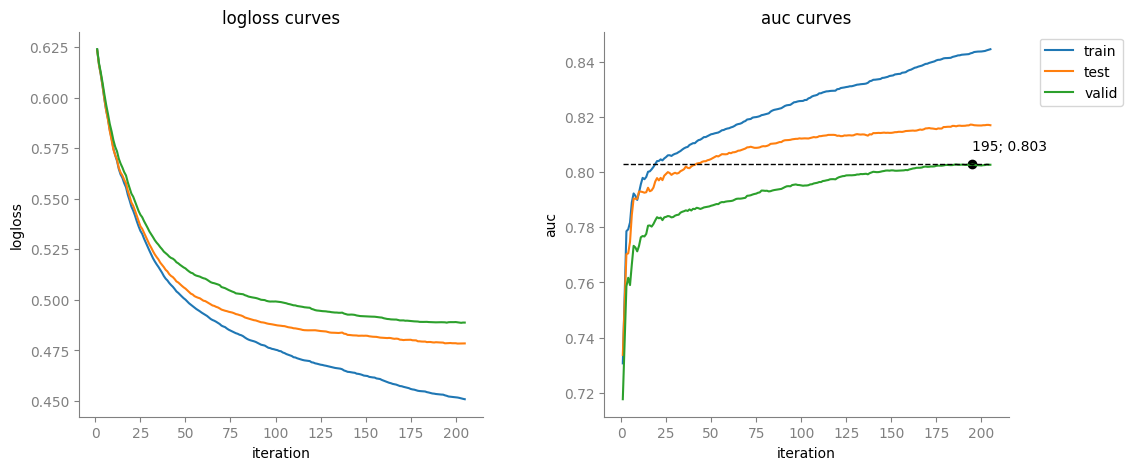

In [164]:
metric = 'logloss'

fig, axs = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(wspace=0.3)

total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    axs[0].plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

    
for sample, vals in evals_result.items():
    axs[1].plot(
        range(1, total_iteration_count + 1), 
        vals['auc'],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)

axs[0].set_xlabel('iteration')
axs[0].set_ylabel('logloss')
axs[0].set_title(f'logloss curves')

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['left'].set_color('gray')
axs[0].spines['bottom'].set_color('gray')
axs[0].tick_params(axis='y', colors='gray')
axs[0].tick_params(axis='x', colors='gray')

axs[1].set_xlabel('iteration')
axs[1].set_ylabel('auc')
axs[1].set_title(f'auc curves')

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_color('gray')
axs[1].spines['bottom'].set_color('gray')
axs[1].tick_params(axis='y', colors='gray')
axs[1].tick_params(axis='x', colors='gray')

plt.legend(loc='upper right',  bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))

plt.show()

#### Applying monotone constraints

<span style="color:red">**TO DO:** Define function for marginal dependence.</span>

Function should have following input parameters:
- data ... pd.DataFrame with data to be used for marginal dependence calculation, TARGET is included in this dataframe
- predictor ... name of the predictor to be analysed
- bins ... number of bins to split the predictor into
- col_target ... the TARGET column to compute default date


It should output a graph with the default rate for each bin, for example
marginal_dependence(data[train_mask], 'EXT_SOURCE_1', 10, col_target) should give something like

<img src="marginal_dependence.png" width=400px style="float: left"/>




In [ ]:
def maginal_dependence():
    ...

In [ ]:
positive_monotone_constraint = [
]

negative_monotone_constraint = [
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3'
]

constr = []
for col in cols_pred:
    if col in positive_monotone_constraint:
        constr.append('1')
    elif col in negative_monotone_constraint:
        constr.append('-1')
    else:
        constr.append('0')

constr = '(' + ','.join(constr) + ')'
constr

In [ ]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'monotone_constraints': constr,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred],  data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10,
    verbose_eval = True
)

In [ ]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    plt.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)
plt.xlabel('iteration')
plt.ylabel(metric)
plt.legend(loc='best')
plt.title(f'{metric} curves')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

# Model validation

In [166]:
data['predicted_pd'] = booster.predict(xgb.DMatrix(data[cols_pred]), iteration_range=(0,booster.best_iteration))
data['predicted_score'] = np.log(data['predicted_pd'] / (1 - data['predicted_pd']))

## Plot individual trees

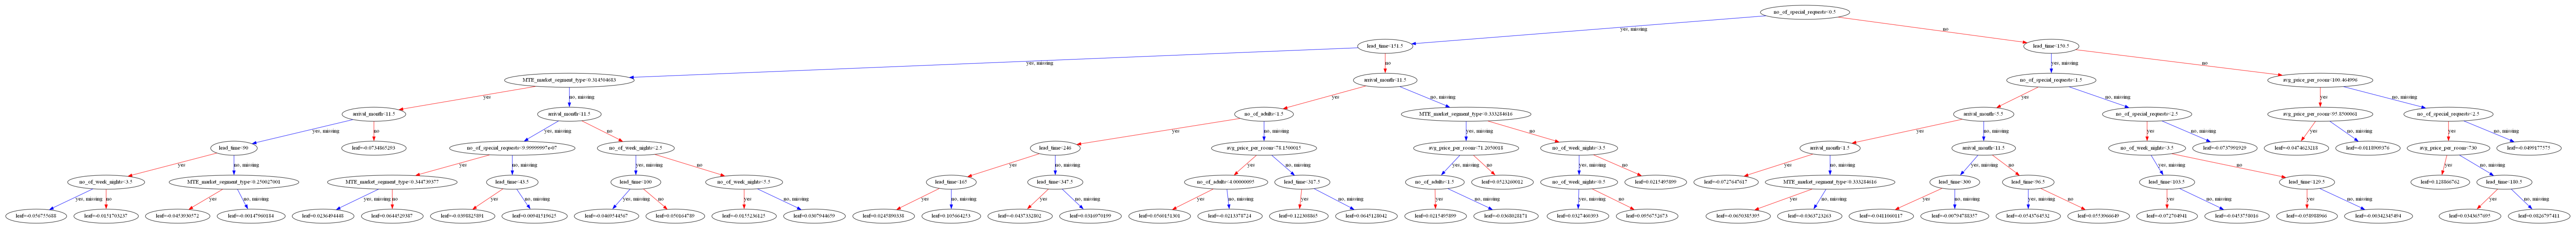

In [167]:
# TODO: To make the following line work you need to install graphviz (if you have not done so in one of the previous classes)
# 1) follow the instructions https://graphviz.gitlab.io/download/?fbclid=IwAR1V-lrRhho5rSfBVYXYISsighqRwOCOgMHLmL_DclkQrPtMXQaKj3mFcqs
# 2) this notebook has been tested with version 8.0.3
# 3) make sure you add it to the PATH variable (you are specifically asked during the installation) at least for local user

from xgboost import plot_tree
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50

plot_tree(booster, num_trees = 0)
plt.show()

rcParams['figure.figsize'] = 5,5

## Score distribution

In [168]:
def plot_score_calibration(dt, col_score, col_target, n_bins = 25):
    min_score = dt[col_score].min() - 0.1
    max_score = dt[col_score].max() + 0.1
    
    bins = [round(min_score + i * (max_score - min_score) / n_bins, 2) for i in range(n_bins+1)]
    dt = dt.assign(score_bin = pd.cut(dt[col_score], bins = bins, include_lowest = False))
    
    dt_grp = dt.groupby('score_bin', observed=False).agg(
        bad_cnt = (col_target, 'sum'),
        tot_cnt = (col_target, len),
        def_rt = (col_target, 'mean'),
        avg_score = (col_score, 'mean')
    )
    dt_grp['good_cnt'] = dt_grp['tot_cnt'] - dt_grp['bad_cnt']
    dt_grp['bad_cnt_norm'] = dt_grp['bad_cnt'] / dt_grp['tot_cnt']
    dt_grp['good_cnt_norm'] = dt_grp['good_cnt'] / dt_grp['tot_cnt']
    dt_grp['expected_pd'] = 1 / (1 + np.exp(-dt_grp['avg_score']))
    
    fig, axs = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle(col_score)
    plt.subplots_adjust(wspace = 0.4)
    axs[0].bar(range(len(dt_grp)), dt_grp['bad_cnt'], color = 'salmon', label = 'bads')
    axs[0].bar(range(len(dt_grp)), dt_grp['good_cnt'], bottom = dt_grp['bad_cnt'], color = 'lightblue', label = 'goods')
    axs[0].set_ylabel('observations count')
    axs[0].set_xlabel('score')
    axs[0].set_xticks(range(len(dt_grp)))
    axs[0].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[0].spines['right'].set_color('gray')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_color('gray')
    axs[0].spines['bottom'].set_color('gray')
    axs[0].tick_params(axis='y', colors='gray')
    axs[0].tick_params(axis='x', colors='gray')
    
    ax0l = axs[0].twinx()
    ax0l.plot(range(len(dt_grp)), dt_grp['def_rt'], marker = 'o', color = 'red')
    ax0l.plot(range(len(dt_grp)), dt_grp['expected_pd'], color = 'black', ls = '--')
    ax0l.set_ylabel('default rate', color = 'red')
    
    ax0l.spines['right'].set_color('gray')
    ax0l.spines['top'].set_visible(False)
    ax0l.spines['left'].set_color('gray')
    ax0l.spines['bottom'].set_color('gray')
    ax0l.tick_params(axis='y', colors='gray')
    ax0l.tick_params(axis='x', colors='gray')
    
    axs[1].bar(range(len(dt_grp)), dt_grp['bad_cnt_norm'], color = 'salmon', label = 'bads')
    axs[1].bar(range(len(dt_grp)), dt_grp['good_cnt_norm'], bottom = dt_grp['bad_cnt_norm'], color = 'lightblue', label = 'goods')
    axs[1].set_ylabel('frequency')
    axs[1].set_xlabel('score')
    axs[1].set_xticks(range(len(dt_grp)))
    axs[1].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].tick_params(axis='y', colors='gray')
    axs[1].tick_params(axis='x', colors='gray')

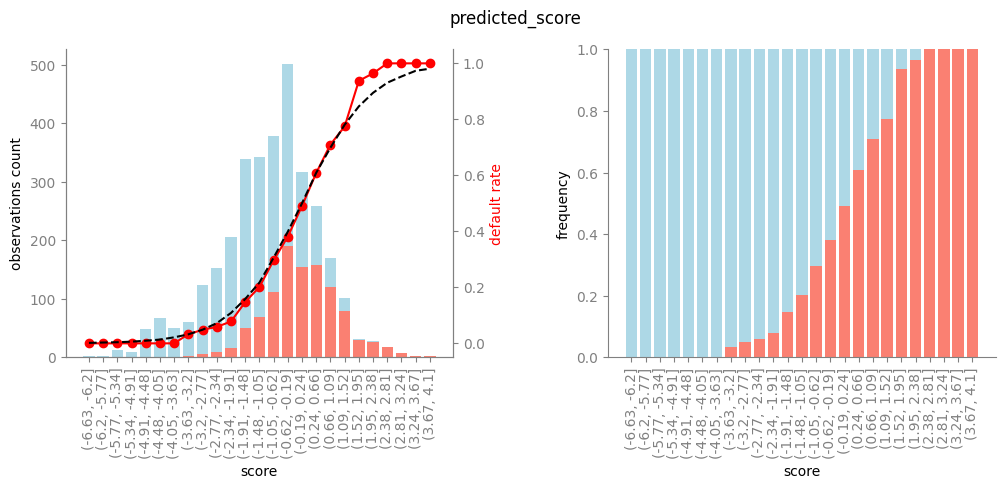

In [169]:
plot_score_calibration(data[valid_mask | test_mask], 'predicted_score', col_target)

## Permutation importance
- Let's have dataset $D$ and model with score (AUC for instance) $s$
- For each feature $j$ calculate permutation importance as follows:
    - for $k$ in $1,\ldots,K$:
        - shuffle column $j$ in dataset $D$ -> $\hat{D}_{k,j}$
        - compute the score $s_{k,j}$ using $\hat{D}_{k,j}$
    - importance $i_j$ for feature $f_j$ is defined as:
$$i_j = s - \frac{1}{K}\sum_{k=1}^K s_{k,j}$$

In [35]:
from sklearn.inspection import permutation_importance

In [36]:
# for sklearn, there is a function
r = permutation_importance(booster_sklearn, data[test_mask][cols_pred], data[test_mask][col_target], n_repeats=6)

In [37]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{cols_pred[i]:<8}    "
              f"{r.importances_mean[i]:.4f}"
              f" +/- {r.importances_std[i]:.4f}")

AMT_CREDIT    0.0005 +/- 0.0002
LAST_TRANSACTION_TIME_MONTHS    0.0002 +/- 0.0001
YEARS_BEGINEXPLUATATION_MEDI    0.0001 +/- 0.0000


In [38]:
def permutation_importance(dt, predictor, target, model, n_iters = 10):
    predictors = list(dt.columns)
    predictors.remove(target)
    
    prediction = model.predict(xgb.DMatrix(dt[predictors]), iteration_range=(0,model.best_iteration))
    s = roc_auc_score(dt[target], prediction)
    
    sk = []
    for i in range(n_iters):
        x = dt[predictor].to_list()
        np.random.shuffle(x)
        dt[predictor] = x
        prediction = model.predict(xgb.DMatrix(dt[predictors]), iteration_range=(0,model.best_iteration))
        sk.append(roc_auc_score(dt[target], prediction))
    
    sk_mean = np.mean(sk)
    sk_perc05 = np.percentile(sk, q=5)
    sk_perc95 = np.percentile(sk, q=95)
    
    return s - sk_mean, s - sk_perc05, s - sk_perc95    

In [39]:
res = []
for pred in tqdm(cols_pred[0:10]):
    pi, iqr95, iqr05 = permutation_importance(
        dt=data[test_mask][cols_pred + [col_target]], 
        predictor=pred,
        target=col_target,
        model=booster,
        n_iters=10
    )
    res.append((pred, pi, iqr05, iqr95))
res = pd.DataFrame(res, columns = ['predictor', 'permutation_importance', 'iqr05', 'iqr95'])
res

  0%|          | 0/10 [00:00<?, ?it/s]

,predictor,permutation_importance,iqr05,iqr95
0,CNT_CHILDREN,0.000055,-0.000031,0.000175
1,AMT_INCOME_TOTAL,-0.000091,-0.000190,0.000040
2,AMT_CREDIT,0.005137,0.003112,0.007115
3,AMT_ANNUITY,0.003547,0.002582,0.005227
4,AMT_GOODS_PRICE,0.008705,0.006394,0.011931
5,REGION_POPULATION_RELATIVE,0.000018,-0.000201,0.000282
6,DAYS_BIRTH,0.002190,0.001383,0.003270
7,DAYS_EMPLOYED,0.002630,0.001919,0.003418
8,DAYS_REGISTRATION,0.000174,-0.000522,0.000813
9,DAYS_ID_PUBLISH,0.001644,0.000670,0.002513


## Marginal contribution

In [170]:
def fit_model(predictors):
    params={
        'eta': 0.2,
        'max_depth': 3,

        'eval_metric': 'auc',
        'objective': 'binary:logistic' ,
        'booster': 'gbtree',
        'tree_method': 'hist',

        'base_score': 0.08,

        'seed': 12
    }

    evals_result = {}

    booster_mc = xgb.train(
        params = params,
        dtrain = xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]), 'train'),
            (xgb.DMatrix(data[test_mask][predictors], data[test_mask][col_target]), 'test'),
            (xgb.DMatrix(data[valid_mask][predictors], data[valid_mask][col_target]), 'valid')
        ),
        evals_result = evals_result,
        early_stopping_rounds = 20
    )
    
    
    prediction = booster_mc.predict(xgb.DMatrix(data[test_mask][predictors]))
    return roc_auc_score(data[test_mask][col_target], prediction)

prediction = booster.predict(xgb.DMatrix(data[test_mask][cols_pred]), iteration_range=(0,booster.best_iteration))
auc_base = roc_auc_score(data[test_mask][col_target], prediction)

marginal_contribution = []
for pred in tqdm(cols_pred[0:5]):
    auc = fit_model(predictors=[p for p in cols_pred if p != pred])
    marginal_contribution.append((pred, auc_base - auc))

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	train-auc:0.68354	test-auc:0.69209	valid-auc:0.65579
[1]	train-auc:0.71878	test-auc:0.72562	valid-auc:0.69509
[2]	train-auc:0.74267	test-auc:0.74670	valid-auc:0.72205
[3]	train-auc:0.75588	test-auc:0.75308	valid-auc:0.73307
[4]	train-auc:0.76691	test-auc:0.76899	valid-auc:0.74405
[5]	train-auc:0.77027	test-auc:0.77227	valid-auc:0.74479
[6]	train-auc:0.77329	test-auc:0.77601	valid-auc:0.74953
[7]	train-auc:0.77812	test-auc:0.77727	valid-auc:0.75712
[8]	train-auc:0.78007	test-auc:0.78076	valid-auc:0.75840
[9]	train-auc:0.78271	test-auc:0.78372	valid-auc:0.75951
[10]	train-auc:0.78385	test-auc:0.78466	valid-auc:0.76060
[11]	train-auc:0.78601	test-auc:0.78723	valid-auc:0.76174
[12]	train-auc:0.78752	test-auc:0.78955	valid-auc:0.76238
[13]	train-auc:0.78784	test-auc:0.79063	valid-auc:0.76286
[14]	train-auc:0.78884	test-auc:0.78977	valid-auc:0.76621
[15]	train-auc:0.78988	test-auc:0.79074	valid-auc:0.76683
[16]	train-auc:0.79072	test-auc:0.79172	valid-auc:0.76727
[17]	train-auc:0.79181	t

In [171]:
marginal_contribution = sorted(marginal_contribution, key=lambda x: x[1], reverse=False)

In [172]:
marginal_contribution

[('no_of_weekend_nights', 0.007500689578117892),
 ('required_car_parking_space', 0.011276784436134557),
 ('no_of_week_nights', 0.011441759454203226),
 ('no_of_adults', 0.012628008393649637),
 ('lead_time', 0.02280408649229937)]

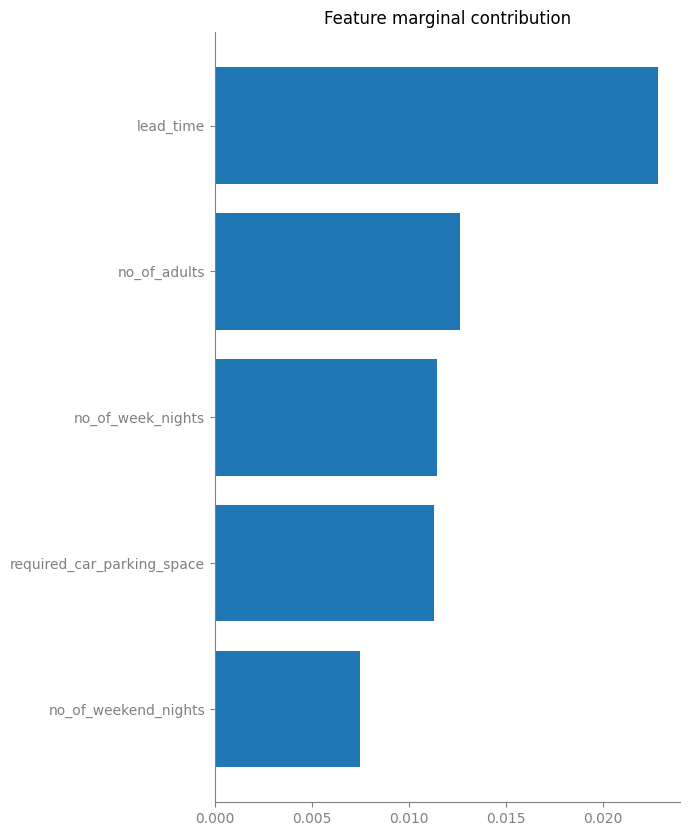

In [173]:
# feature_perm_importance = sorted(zip(cols_pred, pi['importances_mean']), key=lambda x: x[1], reverse=False)

plt.figure(figsize=(6,10))
ax = plt.subplot(1,1,1)
ax.barh(range(len(marginal_contribution)), [imp for p, imp in marginal_contribution])
ax.set_yticks(range(len(marginal_contribution)))
ax.set_yticklabels([p for p, imp in marginal_contribution])

ax.set_title('Feature marginal contribution')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.tick_params(axis='y', colors='gray')

plt.show()

## PDP plots
- PDP = Partial Dependence Plot

In [174]:
def partial_dependency(bst, X, y, feature_names, feature_ids = [], f_id = -1):

    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """
    X_temp = X.copy()
    grid = np.linspace(
        np.percentile(X_temp[:, f_id], 0.1),
        np.percentile(X_temp[:, f_id], 99.5),
        50
    )
    y_pred = np.zeros(len(grid))

    if len(feature_ids) == 0 or f_id == -1:
        print ('Input error!')
        return
    else:
        for i, val in enumerate(grid):

            X_temp[:, f_id] = val
            data = xgb.DMatrix(X_temp, feature_names = feature_names)

            y_pred[i] = np.average(bst.predict(data))

    return grid, y_pred

In [175]:
lst_f = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
# cols_pred
sampled_data = data.sample(frac=0.1, random_state=22)
for f in lst_f:
    f_id = cols_pred.index(f)
    feature_ids = range(len(cols_pred))

    mask = sampled_data[f].notnull()
    grid, y_pred = partial_dependency(
        booster,
        sampled_data[mask][cols_pred].values,
        sampled_data[mask][col_target].values,
        feature_names = cols_pred,
        feature_ids = feature_ids,
        f_id = f_id
    )

    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

    ax.plot(grid, y_pred, ls = '-', color = 'red', linewidth = 1.5, label='fit')

    ax.set_xlim(min(grid), max(grid))
    ax.set_ylim(0.98 * min(y_pred), 1.02 * max(y_pred))

    ax.set_title(f)
    ax.set_ylabel('Partial Dependence')
    plt.xticks(rotation=45)

    plt.show()

ValueError: 'EXT_SOURCE_1' is not in list

## ICE plots
- ICE = Individual Conditional Expectation

In [176]:
def ice_data(bst, dt, predictor, n_points=20):
    X = dt.copy()
    grid = np.linspace(
        dt[predictor].quantile(0.01),
        dt[predictor].quantile(0.99),
        n_points
    )
    
    y_pred = np.zeros((len(dt), len(grid)))

    if len(feature_ids) == 0 or f_id == -1:
        print ('Input error!')
        return
    else:
        for i, val in enumerate(grid):
            X[predictor] = val
            data = xgb.DMatrix(X, feature_names = X.columns.to_list())

            y_pred[:,i] = bst.predict(data)

    return grid, y_pred

In [177]:
n_plots = 100
cols_to_plot = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

sampled_data = data.sample(n=10000, random_state=22)

for pred in cols_to_plot:
    x, ice_data_plot = ice_data(booster, sampled_data[cols_pred], pred)

    idx = np.random.randint(len(x), size=n_plots)
    plt.plot(x, np.transpose(ice_data_plot[idx,:]), lw = 0.5, color = 'lightblue')
    plt.plot(x, np.average(ice_data_plot[idx,:], axis = 0), lw = 2, ls = '--', color = 'blue', label = 'Partial dependance curve')
    plt.title(pred)
    plt.ylabel('Predicted value')
    plt.xlabel('Values')
    plt.legend(loc='best')
    plt.show()

KeyError: 'EXT_SOURCE_1'

## SHAP
- SHAP = SHapley Additive exPlanations
- Original paper presenting SHAP values can be downloaded here: <a href=https://arxiv.org/abs/1705.07874 target="_blank">SHAP values</a>
- SHAP values are defined by following equation:
$$ \phi_i = \sum_{S\subseteq F\setminus\lbrace i \rbrace} \frac{|S|!(|F|-|S|-1)!}{|F|!} [f_{S\cup \lbrace i\rbrace}(x_{S\cup \lbrace i\rbrace})-f_S(x_S)] $$
where:

    - $F$ ... set of all model features
    - $S$ ... $S \subseteq F \setminus\lbrace i\rbrace$
    - $\phi_i$ ... SHAP value for predictor $x_i$
    - $f_S(x_S)$ ... output of model build on feature set $S$ given feature values $x_S$

In [179]:
import shap
shap.initjs()

In [181]:
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(data[cols_pred])

In [ ]:
plt.figure()
shap.summary_plot(shap_values, data[cols_pred], max_display=20, show=True)
plt.show()

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], data[cols_pred].iloc[0,:])

In [ ]:
shap.plots._waterfall.waterfall_legacy(
    expected_value=explainer.expected_value, 
    shap_values=shap_values[0, :], 
    feature_names=cols_pred, 
    max_display=20
)

### SHAP interaction values

In [ ]:
Xd = xgb.DMatrix(data[train_mask][cols_pred].iloc[:1000], data[train_mask][col_target].iloc[:1000])

explainer = shap.TreeExplainer(booster)
shap_interaction_values = explainer.shap_interaction_values(Xd)

In [ ]:
plt.figure(figsize=(15,13))

sns.heatmap(
    data=np.mean(abs(shap_interaction_values[:, 0:20, 0:20]), axis=0), 
    annot=True, 
    fmt='.2f', 
    xticklabels=cols_pred[0:20], 
    yticklabels=cols_pred[0:20],
    cmap='winter',
    vmax=0.05
)

plt.show()

In [ ]:
n_observations = 10000

dt_shap = data.iloc[0:n_observations]
dt_shap = dt_shap[cols_pred]
shap.dependence_plot('AMT_GOODS_PRICE', shap_values[:n_observations], dt_shap, interaction_index = 'AMT_CREDIT')

Better example of high interaction: https://h1ros.github.io/posts/explain-the-interaction-values-by-shap/

In [ ]:
# def marginal_dependence(data, predictor, bins, col_target):
#     dt = data.copy()
#     dt[predictor + 'bin'] = pd.qcut(dt[predictor], bins).copy()
#     dt.groupby(predictor + 'bin').agg(
#         def_rt=(col_target, np.mean),
#     ).plot(figsize=(9, 6))